# Scouting analysis - Premier League 2017/2018

In [1]:
# Imports
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager, add_image
# add image
from urllib.request import urlopen
from PIL import Image

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Get Data
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "events", 'events_France.json') 
with open(path) as f: 
    data = json.load(f) 
train = pd.DataFrame(data) 

train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

In [3]:
# Turnovers
def turnovers(df):
    dribble_forward = df.loc[df["subEventName"] == "Ground attacking duel"]
    lost_dribble_forward = dribble_forward.loc[dribble_forward.apply(lambda x:{'id':701} in x.tags, axis = 1)]
    ldf = lost_dribble_forward.groupby(["playerId"]).eventId.count().reset_index()
    ldf.rename(columns = {'eventId':'lost_dribble_forward'}, inplace=True)
    
    passes = df.loc[df["eventName"] == "Pass"]
    lost_pass = passes.loc[passes.apply(lambda x:{'id':1802} in x.tags, axis = 1)]
    lp = lost_pass.groupby(["playerId"]).eventId.count().reset_index()
    lp.rename(columns = {'eventId':'lost_pass'}, inplace=True)

    turnovers_made = ldf.merge(lp, how = "outer", on = ["playerId"])

    return turnovers_made

turnover = turnovers(train)

In [4]:
# Clearances 
def clearance(df):
    clearance = df.loc[df["subEventName"] == "Clearance"]
    clearing_player = clearance.groupby(["playerId"]).eventId.count().reset_index()
    clearing_player.rename(columns = {'eventId':'clearances'}, inplace=True)

    return clearing_player

clear = clearance(train)

In [5]:
# Interceptions
def interception(df):
    opp_pass = df.loc[df["eventName"] == "Pass"]
    interception = opp_pass.loc[opp_pass.apply(lambda x:{'id':1401} in x.tags, axis = 1)]
    intercepting_player = interception.groupby(["playerId"]).eventId.count().reset_index()
    intercepting_player.rename(columns = {'eventId':'interceptions'}, inplace=True)

    return intercepting_player

intercept = interception(train)

In [6]:
# Duels Won
def defensiveDuelsWon(df):
    loose_duels = df.loc[df["subEventName"] == "Ground loose ball duel"]
    won_loose_duels = loose_duels.loc[loose_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wld_player = won_loose_duels.groupby(["playerId"]).eventId.count().reset_index()
    wld_player.rename(columns = {'eventId':'loose_duels_won'}, inplace=True)
    
    def_ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = def_ground_duels.loc[def_ground_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wgd_player = won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'def_ground_duels_won'}, inplace=True)

    air_duels = df.loc[df["subEventName"].isin(["Air duel"])]
    won_air_duels = air_duels.loc[air_duels.apply(lambda x:{'id':703} in x.tags, axis = 1)]
    wad_player = won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)
    
    duels_won = wgd_player.merge(wld_player, how = "outer", on = ["playerId"]).merge(wad_player, how = "outer", on = ["playerId"])

    return duels_won

duels = defensiveDuelsWon(train)

In [7]:
# Turnover calculations
def calc(values, percentiles):
    lost_pass = values[-1]
    values.pop()
    lost_dribble = values[-1]
    values.pop()
    turnovers = lost_pass + lost_dribble # how many turnovers per 90 min

    lost_pass_perc = percentiles[-1]
    percentiles.pop()
    lost_dribble_perc = percentiles[-1]
    percentiles.pop()

    values_new = values.append(turnovers)
    percentiles_new = percentiles.append(135-turnovers*10)

    return percentiles_new, values_new

In [8]:
# Minutes per game calculations 
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', "minutes_played", 'minutes_played_per_game_France.json') 
with open(path) as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

In [9]:
# Summary
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(duels, how = "left", on = ["playerId"]).merge(intercept, how = "left", on = ["playerId"]).merge(clear, how = "left", on = ["playerId"]).merge(turnover, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

In [11]:
# Positions
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'src', 'wyscout', 'players.json')
with open(path) as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Defender", axis = 1)]
forwards.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])

In [12]:
# Per 90
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

## Players


         firstName           lastName  interceptions_per_90
97         Mathieu            Debuchy              4.576271
225     Mehdi Jean             Tahrat              3.913043
428          Felix          Eboa Eboa              3.627204
180    C\u00e9dric           Varrault              3.453947
243         Oualid          El Hajjam              3.413252
140        Mathieu           Deplagne              3.277311
455           Ramy         Bensebaini              3.099631
260          Pablo  Nascimento Castro              3.084948
365      Alexander              Djiku              3.065442
137  Ba\u00efssama             Sankoh              3.026152

In [66]:
player_name = "B. Sankoh" 

#only his statistics
player = summary_per_90.loc[summary_per_90["shortName"] == player_name]
#columns similar together
player = player[["loose_duels_won_per90", "def_ground_duels_won_per90", "air_duels_won_per90", "interceptions_per90", "clearances_per90", "lost_dribble_forward_per90", "lost_pass_per90"]]
#take only necessary columns - exclude playerId
per_90_columns_player = player.columns[:]
#values to mark on the plot
values_player = [round(player[column].iloc[0],2) for column in per_90_columns_player]
#percentiles
percentiles_player = [int(stats.percentileofscore(summary_per_90[column], player[column].iloc[0])) for column in per_90_columns_player]
# calculate turnovers
calc(values_player, percentiles_player)
# rounding
values_player = [ round(elem, 2) for elem in values_player ]
percentiles_player = [ round(elem, 2) for elem in percentiles_player ]

Mean of percentiles:  72.8


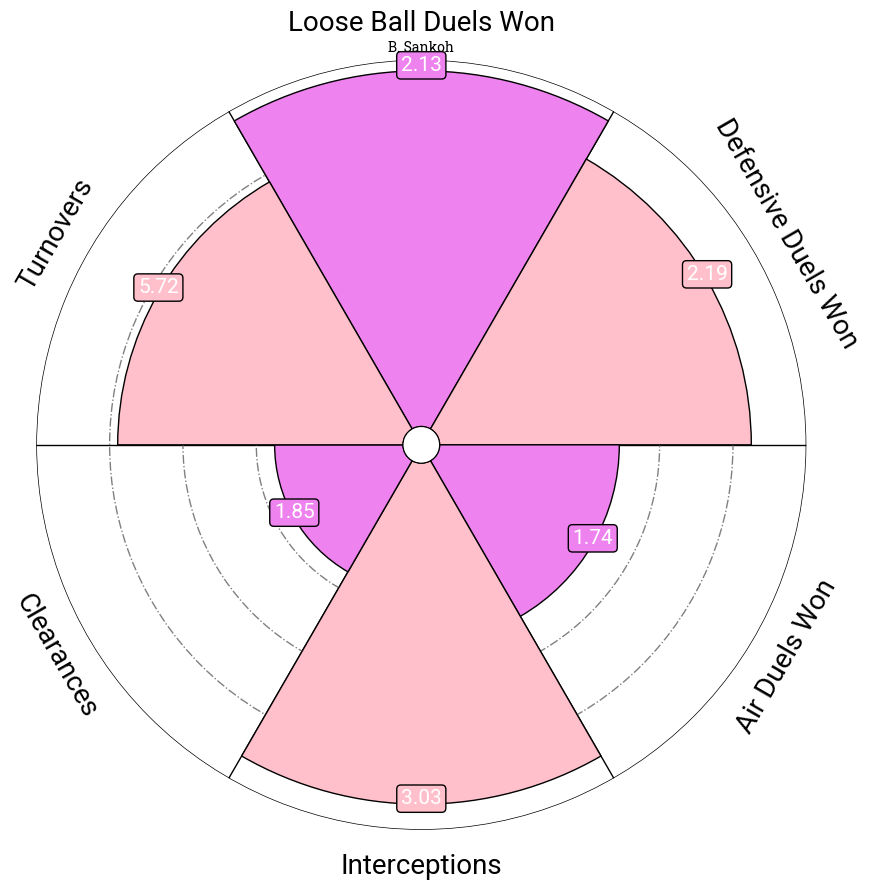

In [67]:
#list of names on plots
names = ["Loose Ball Duels Won", "Defensive Duels Won", "Air Duels Won", "Interceptions", "Clearances", "Turnovers"]
num = len(names)
slice_colors = ["violet"] + ["pink"] + ["violet"] + ["pink"] + ["violet"] + ["pink"]
text_colors = ["white"] * num
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    background_color="white",
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    
    percentiles_player,              # list of values,
    #compare_values=percentiles_player,
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors = slice_colors,
    value_colors = text_colors,
    value_bck_colors = slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="lightskyblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting comparison slices
    kwargs_params=dict(
        color="#000000", fontsize=20,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=15,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="000000",
            boxstyle="round,pad=0.2", lw=1
        )
    )                # values to be used when adding parameter-values  
)

ax.set_title(player_name, fontsize=20, fontproperties=font_bold.prop, color="#000000")

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values_player[i]))

# print the mean of the percentiles
print("Mean of percentiles: ", np.mean(percentiles_player))